# Earthquake Magnitude Prediction

### Introduction

In this notebook, my aim will be to develop, train, and evaluate three different machine learning models to predict earthquake magnitudes based on a set of temporal, geographic, and seismic features. The models considered in this notebook are:

1. **Linear Regression**
2. **Random Forest Regressor**
3. **Artificial Neural Network (ANN)**

The ultimate goal is to compare the performance of these models and select the one that yields the best performance for the prediction task. The model with the best performance will be chosen based on its ability to accurately predict earthquake magnitudes, evaluated using a variety of metrics such as Mean Squared Error (MSE) and Root Mean Squared Error (RMSE).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Import the dataset as a DataFrame
df = pd.read_csv('data.csv')

# Check the data has been imported
df.head()

,date,time,latitude,longitude,depth,magnitude
0,2008-11-01,00:31:25,-0.60,98.89553,20.0,2.99
1,2008-11-01,01:34:29,-6.61,129.38722,30.1,5.51
2,2008-11-01,01:38:14,-3.65,127.99068,5.0,3.54
3,2008-11-01,02:20:05,-4.20,128.09700,5.0,2.42
4,2008-11-01,02:32:18,-4.09,128.20047,10.0,2.41


In [3]:
# Check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87372 entries, 0 to 87371
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       87372 non-null  object 
 1   time       87372 non-null  object 
 2   latitude   87372 non-null  float64
 3   longitude  87372 non-null  float64
 4   depth      87372 non-null  float64
 5   magnitude  87372 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.0+ MB


__No missing data__

## Feature Engineering

The following block merges the 'date' and 'time' columns into a single 'datetime' column using __pd.to_datetime()__. This combined 'datetime' column allows us to easily extract various components such as year, month, day, hour, minute, and second using the __.dt__ attributes.

In [4]:
# Combine 'date' and 'time' into a single datetime column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Convert to datetime (in case you want to ensure correct type)
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract year, month, day, hour, minute, second
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute

# Extract day of the week
df['weekday'] = df['datetime'].dt.weekday


### Cyclic Transformations of Temporal Features

In the next block of code, cyclic transformations are applied to temporal features (month, day, hour, minute, and weekday) to capture their periodic nature and preserve continuity. For each feature, two new columns are created using sine and cosine functions to represent the cyclical nature:

- **Month**:
  - `df['month_sin']` and `df['month_cos']` transform the month feature into cyclic components.
  - Sine and cosine functions map the month values (1 to 12) onto a unit circle, capturing the periodicity of months within a year.

- **Day**:
  - `df['day_sin']` and `df['day_cos']` perform a similar transformation for the day of the month.
  - Assuming a maximum of 31 days, these transformations account for the cyclical pattern of days within a month.

- **Hour**:
  - `df['hour_sin']` and `df['hour_cos']` convert the hour feature into cyclic components.
  - The sine and cosine functions map the hour values (0 to 23) onto a unit circle, capturing the 24-hour daily cycle.

- **Minute**:
  - `df['minute_sin']` and `df['minute_cos']` apply cyclic transformations to the minute feature.
  - With a range from 0 to 59, these transformations capture the repeating pattern of minutes within an hour.

- **Weekday**:
  - `df['weekday_sin']` and `df['weekday_cos']` transform the weekday feature into cyclic features.
  - The weekday values (0 for Monday to 6 for Sunday) are mapped onto a unit circle to reflect the weekly cycle.

These cyclic transformations are useful in machine learning models as they encode temporal features in a way that maintains their natural periodic relationships, enhancing model performance and interpretability.


In [5]:
# Transform month to cyclic features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Transform day to cyclic features
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  # Assuming max 31 days in a month
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# Transform hour to cyclic features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Transform minute to cyclic features
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

# Transform weekday to cyclic features
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

The following code simply reorganises the DataFrame so that the __"year"__ column and all the columns relating to the new __cyclic features__ are on the left of the dataframe followed by the remaining columns.

In [6]:
# List of new date/time columns
cyclic_columns = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'weekday_sin', 'weekday_cos']

# List of remaining columns
remaining_columns = [col for col in df.columns if col not in cyclic_columns]

# Create new column order
new_column_order = cyclic_columns + remaining_columns

# Reorder DataFrame columns
df = df[new_column_order]

# Drop the original columns as they are now redundant
df.drop(columns=['month', 'day', 'hour', 'minute', 'weekday'], inplace=True)

# Move "year" to first column
df = df[['year','month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'minute_sin', 'minute_cos', 'weekday_sin', 'weekday_cos',
       'latitude', 'longitude', 'depth', 'magnitude']]


The DataFrame has been systematically organised to reflect all engineered features. The resulting dataset, which includes the newly created cyclic features, is presented below, and is optimised for subsequent analysis and modeling.

In [7]:
# Review the modified dataset
df.head()

,year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,weekday_sin,weekday_cos,latitude,longitude,depth,magnitude
0,2008,-0.5,0.866025,0.201299,0.97953,0.000000,1.000000,-0.104528,-0.994522,-0.974928,-0.222521,-0.60,98.89553,20.0,2.99
1,2008,-0.5,0.866025,0.201299,0.97953,0.258819,0.965926,-0.406737,-0.913545,-0.974928,-0.222521,-6.61,129.38722,30.1,5.51
2,2008,-0.5,0.866025,0.201299,0.97953,0.258819,0.965926,-0.743145,-0.669131,-0.974928,-0.222521,-3.65,127.99068,5.0,3.54
3,2008,-0.5,0.866025,0.201299,0.97953,0.500000,0.866025,0.866025,-0.500000,-0.974928,-0.222521,-4.20,128.09700,5.0,2.42
4,2008,-0.5,0.866025,0.201299,0.97953,0.500000,0.866025,-0.207912,-0.978148,-0.974928,-0.222521,-4.09,128.20047,10.0,2.41


## Splitting the Data

Before training a (machine learning) model the data must be prepared accordingly by separating the features from the target variable. The data will then be split into __training__ and __test__ sets using the __train_test_split__ function in scikit-learn, with 20% of the data reserved for testing and the remaining 80% used for training. The __random_state__ parameter ensures that the split is reproducible. This process allows us to evaluate the performance of our model on unseen data and helps to mitigate overfitting.

In [8]:
# Sample data
X = df.drop('magnitude',axis=1)
y = df['magnitude']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model 1: Linear Regression Model

In this section, we will prepare and evaluate a __linear regression model__ using scikit-learn. The training data established previously is __scaled__ to standardise its features, while the test data is scaled accordingly without any re-fitting. The model, based on __ElasticNetCV__, performs __cross-validation__ to find the best combination of regularisation parameters (__alpha__ and __l1_ratio__) for the model. After training the model with the optimal parameters, it will be used to predict outcomes on the test set and assess its performance by calculating the __Mean Squared Error (MSE)__ and __Mean Absolute Error (MAE)__, to characterise the model's accuracy and error margins.

In [9]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time

start_time = time.time()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale training data
scaler = StandardScaler()
X_train_Scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)        # Only transform the test data

# Define a range of alphas and l1_ratios for Elastic Net regularisation
alphas = np.logspace(-4, 0, 50)
l1_ratios = np.linspace(0.1, 0.9, 9)

# Instantiate and fit ElasticNetCV with cross-validation
elasticnet_cv = ElasticNetCV(l1_ratio = l1_ratios, alphas=alphas, cv = 5)
elasticnet_cv.fit(X_train_Scaled, y_train)

# Best hyperparameters
best_alpha = elasticnet_cv.alpha_
best_l1_ratio = elasticnet_cv.l1_ratio_

print(f'Best Alpha: {best_alpha}')
print(f'Best L1 Ratio: {best_l1_ratio}')


# test model
y_pred = elasticnet_cv.predict(X_test_scaled)

# Calculate the MSE of the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

# Calculate MAE for the ElasticNet model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on Test Set: {mae}')

end_time = time.time() - start_time

print(f'time taken to train = {end_time/60: 0.2f} minutes')

Best Alpha: 0.0009540954763499944
Best L1 Ratio: 0.9
Mean Squared Error on Test Set: 0.5500698521912939
Mean Absolute Error on Test Set: 0.5956669287513737
time taken to train =  0.03 minutes


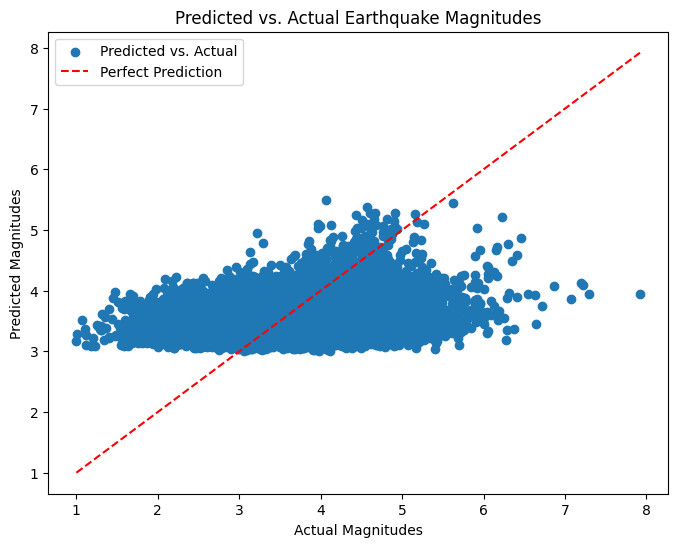

In [10]:
# Scatter plot of predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Magnitudes')
plt.ylabel('Predicted Magnitudes')
plt.title('Predicted vs. Actual Earthquake Magnitudes')
plt.legend()
plt.show()

The blue points represent the predicted magnitudes plotted against the actual magnitudes. The points should ideally align along the red dashed line if the model were perfectly accurate. This line represents the "Perfect Prediction," where the predicted magnitudes exactly match the actual magnitudes. Deviations from this line show the model's error. The spread of points around the red line indicates the model's performance. The closer the points are to the line, the better the model is at predicting the actual magnitudes. However, in this plot, there is a noticeable spread, indicating some error in predictions, which is typical for linear regression in complex datasets.

## Model 2: Random Forest Model

In the following blocks, we train and evaluate a Random Forest Regressor using scikit-learn. It is noted that scaling is not needed for Random Forest models due to their inherent structure and functionality. Random Forests are an ensemble method that builds multiple decision trees and aggregates their predictions. These trees make decisions based on feature splits at various thresholds, which are not influenced by the scale of the features.

To optimise the model, a grid search strategy (__GridSearchCV__) will be used to explore various hyperparameters, specifically __n_estimators__ and __max_depth__, with __cross-validation__ to identify the best parameter combination. After fitting the grid search, the best parameters will be identified along with the corresponding score. As part of the performance evaluation the training time will also be measured and then the best model will be used to make predictions on the test set. The model's performance will be characterised by calculating the __Mean Squared Error (MSE), Root Mean Squared Error (RMSE)__, and __Mean Absolute Error (MAE)__, providing a comprehensive assessment of its accuracy and predictive performance.


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

start_time = time.time()

# Instantiate and fit Random Forest Regressor
rf_regr = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_regr.fit(X_train, y_train)

# Define a parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

# Instantiate the RandomForestRegressor with parallel processing
rf_regr = RandomForestRegressor(random_state=42, n_jobs=-1)

# Instantiate GridSearchCV with parallel processing
rfr_grid = GridSearchCV(estimator=rf_regr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV
rfr_grid.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", rfr_grid.best_params_)
print("Best Score (Negative MSE):", rfr_grid.best_score_)

end_time = time.time() - start_time

print(f'time taken to train = {end_time/60: 0.2f} minutes')


Best Parameters: {'max_depth': None, 'n_estimators': 300}
Best Score (Negative MSE): -0.32639941133918576
time taken to train =  11.96 minutes


In [12]:
# Predict using the best model
best_rf = rfr_grid.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error on Test Set: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')

Mean Squared Error on Test Set: 0.31840750547315205
Root Mean Squared Error on Test Set: 0.5642760897585083
Mean Absolute Error on Test Set: 0.43429063805436335


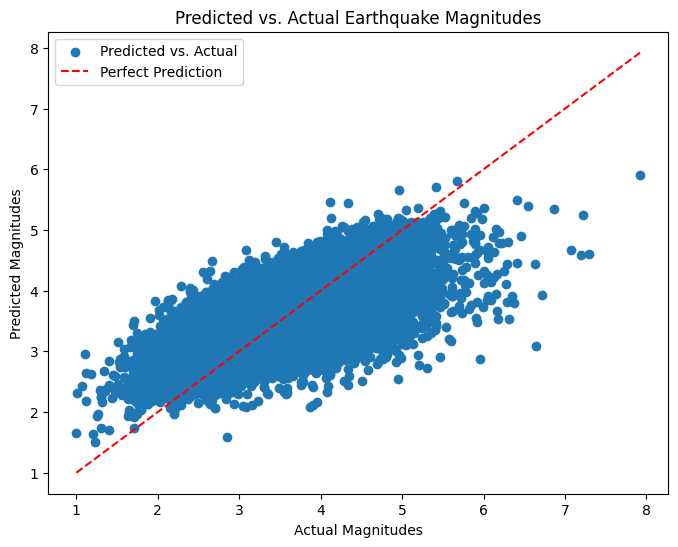

In [13]:
# Scatter plot of predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Magnitudes')
plt.ylabel('Predicted Magnitudes')
plt.title('Predicted vs. Actual Earthquake Magnitudes')
plt.legend()
plt.show()

Compared to the Linear Regression model, the points here seem to cluster more closely around the red dashed line, especially in the mid-range of magnitudes (around 3 to 5). This suggests that the Random Forest model is more accurate, particularly for the majority of the data points.

## Model 3: Artificial Neural Network

The final model considered in this notebook is a Neural Network that will be built using PyTorch. It will consist of three __fully connected layers__ with 200, 100, and 1 neuron(s) respectively, incorporating __batch normalisation__ to stabilise learning and __dropout__ to prevent overfitting. The network uses __ReLU__ activation functions and __Xavier__ initialisation for weights to improve convergence. Training is performed using __mean squared error (MSE) loss__ and the __Adam optimiser__, with __learning rate__ adjustments (-another hyperparameter) via a scheduler to enhance performance. The training process includes __early stopping__ to prevent overfitting, and the model's performance is evaluated on the test set. The loss is plotted to visualize training progress, and the total training time is recorded.

### Data Preparation & Optimisation

Before building the Neural Network there are several steps needed in order to make the data compatible for use in a PyTorch neural network. Firstly, the feature and label data must be __converted to numpy arrays__. Features must then be standardised using __StandardScaler__ to ensure they have a mean of zero and a standard deviation of one. Likewise, labels are normalised using __MinMaxScaler__ to scale them to a range between 0 and 1. The normalised data must be converted into __PyTorch tensors__ for compatibility with neural network operations. A custom __Dataset__ class will also be defined to facilitate data handling, and __DataLoader__ instances are created for both training and testing datasets to manage batching and shuffling of data during training. This setup ensures that data is properly formatted and efficiently fed into the model.

__Optuna__ will be used to optimise hyperparameters such as __hidden layer sizes, dropout rate,__ and __learning rate__. The objective function trains the model for a set number of epochs, and the __study.optimize__ method finds the best hyperparameters by minimising the loss. Optuna is used instead of traditional methods like Grid Search CV because it is more efficient and flexible for hyperparameter optimisation. Unlike Grid Search CV, which evaluates all possible combinations of specified parameters, Optuna uses a smarter, guided search approach called __"sequential optimisation"__ that __focuses on promising regions of the parameter space__. This makes it significantly faster, especially for complex models with many hyperparameters. Additionally, Optuna can handle continuous and discrete hyperparameters seamlessly and supports advanced features like early stopping, further improving the optimisation process.

In [14]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_size1 = trial.suggest_int('hidden_size1', 64, 256)
    hidden_size2 = trial.suggest_int('hidden_size2', 64, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Define the model
    class EarthquakeModel(nn.Module):
        def __init__(self):
            super(EarthquakeModel, self).__init__()
            self.fc1 = nn.Linear(X.shape[1], hidden_size1)
            self.bn1 = nn.BatchNorm1d(hidden_size1)
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)
            self.bn2 = nn.BatchNorm1d(hidden_size2)
            self.fc3 = nn.Linear(hidden_size2, 1)
            self.dropout = nn.Dropout(dropout_rate)
            self.initialize_weights()
        
        def forward(self, x):
            x = torch.relu(self.bn1(self.fc1(x)))
            x = self.dropout(x)
            x = torch.relu(self.bn2(self.fc2(x)))
            x = self.dropout(x)
            x = self.fc3(x)
            return x
        
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0)
    
    model = EarthquakeModel().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    model.train()
    for epoch in range(10):  # Using fewer epochs for quicker optimization
        running_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
    
    return epoch_loss

# Run the hyperparameter optimisation
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

[I 2024-08-09 20:58:41,146] A new study created in memory with name: no-name-ffb46d2f-8a26-4186-a8cc-3bf4973b81d0
[I 2024-08-09 20:59:38,283] Trial 0 finished with value: 0.4705054144737405 and parameters: {'hidden_size1': 70, 'hidden_size2': 231, 'dropout_rate': 0.10152207407159604, 'learning_rate': 0.001733602310183899}. Best is trial 0 with value: 0.4705054144737405.
[I 2024-08-09 21:00:35,961] Trial 1 finished with value: 0.46529762067108266 and parameters: {'hidden_size1': 221, 'hidden_size2': 162, 'dropout_rate': 0.1473735951883417, 'learning_rate': 0.002565161203526394}. Best is trial 1 with value: 0.46529762067108266.
[I 2024-08-09 21:01:34,662] Trial 2 finished with value: 0.48629119560338446 and parameters: {'hidden_size1': 240, 'hidden_size2': 251, 'dropout_rate': 0.2607536854336213, 'learning_rate': 0.001238675347060428}. Best is trial 1 with value: 0.46529762067108266.
[I 2024-08-09 21:02:31,559] Trial 3 finished with value: 0.6139717204244304 and parameters: {'hidden_size

Best hyperparameters: {'hidden_size1': 204, 'hidden_size2': 124, 'dropout_rate': 0.10148158108849106, 'learning_rate': 0.0038708909970933685}


With the *__optimal hyperparameters__* determined using Optuna, we can now configure and train our final neural network model to achieve the best performance. This setup ensures that the model is fine-tuned for our specific dataset and task, enhancing its predictive accuracy and efficiency.


Epoch 1/100, Training Loss: 0.6524
Epoch 2/100, Training Loss: 0.5233
Epoch 3/100, Training Loss: 0.5011
Epoch 4/100, Training Loss: 0.4905
Epoch 5/100, Training Loss: 0.4804
Epoch 6/100, Training Loss: 0.4739
Epoch 7/100, Training Loss: 0.4689
Epoch 8/100, Training Loss: 0.4683
Epoch 9/100, Training Loss: 0.4662
Epoch 10/100, Training Loss: 0.4639
Epoch 11/100, Training Loss: 0.4513
Epoch 12/100, Training Loss: 0.4484
Epoch 13/100, Training Loss: 0.4486
Epoch 14/100, Training Loss: 0.4464
Epoch 15/100, Training Loss: 0.4470
Epoch 16/100, Training Loss: 0.4456
Epoch 17/100, Training Loss: 0.4433
Epoch 18/100, Training Loss: 0.4441
Epoch 19/100, Training Loss: 0.4426
Epoch 20/100, Training Loss: 0.4416
Epoch 21/100, Training Loss: 0.4410
Epoch 22/100, Training Loss: 0.4408
Epoch 23/100, Training Loss: 0.4396
Epoch 24/100, Training Loss: 0.4398
Epoch 25/100, Training Loss: 0.4392
Epoch 26/100, Training Loss: 0.4391
Epoch 27/100, Training Loss: 0.4391
Epoch 28/100, Training Loss: 0.4384
E

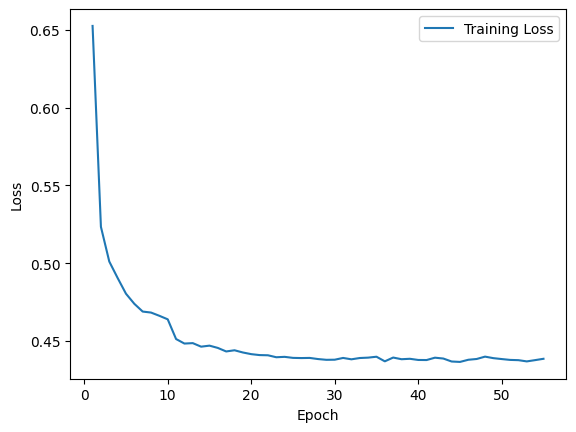

Time taken to train and validate NN model: 321.15273118019104 seconds


In [15]:
# Optimised Neural Network Model

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

start_time = time.time()


# Define the Neural Network (using the optimal parameters)
class EarthquakeModel(nn.Module):
    def __init__(self):
        super(EarthquakeModel, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 204)  # hidden_size1
        self.bn1 = nn.BatchNorm1d(204)
        self.fc2 = nn.Linear(204, 124)  # hidden_size2
        self.bn2 = nn.BatchNorm1d(124)
        self.fc3 = nn.Linear(124, 1)
        self.dropout = nn.Dropout(0.10)  # dropout_rate
        self.initialize_weights()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


# Initialise the model
model = EarthquakeModel()

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EarthquakeModel().to(device)


# Train the Model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0039, weight_decay=1e-5)  # L2 regularization with weight_decay


# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def train_with_scheduler(model, train_loader, criterion, optimizer, scheduler, epochs=20, patience=5):
    model.train()
    train_losses = []
    best_train_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        running_train_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * features.size(0)
        
        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}')

        if train_loss < best_train_loss:
            best_train_loss = train_loss
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model)
            break
    
    return train_losses

# Training with learning rate scheduler and early stopping
epochs = 100
patience = 10
train_losses = train_with_scheduler(model, train_loader, criterion, optimizer, scheduler, epochs, patience)

# Evaluate the Model
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for features, targets in loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            loss = criterion(outputs.squeeze(), targets)
            running_loss += loss.item() * features.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')

# Plotting the loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


end_time = time.time() - start_time

print(f'Time taken to train and validate NN model: {end_time} seconds')


## Model Selection

Since the Random Forest outperformed both the Linear Regression and ANN models, we have selected it to be our final model. We can now save this model to a separate file, which can be loaded and used in other documents.

In [16]:
import joblib

# Save the model to a file
joblib.dump(best_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']